In [6]:
#!/usr/bin/env python3

import torch
from torch_geometric.data import Dataset, Data
import uproot
import numpy as np
import awkward as ak
import os


def read_event(
    tree,
    feature_branches=None,
    pt_cut=0.0,
    bx_branch='gnn_sim_vertex_BX',
    lv_branch='gnn_sim_vertex_isLV',
    label_branch='gnn_sim_vertex_evID'
):

    if feature_branches is None:
        feature_branches = ['gnn_z_pca']

    required_branches = set(feature_branches + [bx_branch, lv_branch, label_branch, 'gnn_pt', 'gnn_dz'])
    for rb in required_branches:
        if rb not in tree.keys():
            print(f"Branch {rb} not found in tree!")
            return None

    branch_data = tree.arrays(list(required_branches), library='ak')

    bx_array = ak.to_numpy(branch_data[bx_branch]).flatten()
    lv_array = ak.to_numpy(branch_data[lv_branch]).flatten()
  
    mask = (bx_array == 0) 

    pt_array = ak.to_numpy(branch_data['gnn_pt']).flatten()
    pt_array = pt_array[mask]
    pt_mask = pt_array >= pt_cut

    if not np.any(pt_mask):       
        return None

    arrays_for_stack = []
    for fb in feature_branches:
        arr = ak.to_numpy(branch_data[fb]).flatten()[mask][pt_mask]
        arr = np.nan_to_num(arr, nan=0.0, posinf=0.0, neginf=0.0)
        arr = arr.reshape(-1, 1)
        arrays_for_stack.append(arr)

    try:
        features = np.hstack(arrays_for_stack).astype(np.float32)
    except ValueError as e:
        print(f"ValueError while stacking features: {e}")
        return None


    labels = ak.to_numpy(branch_data[label_branch]).flatten()[mask][pt_mask]
    labels = np.nan_to_num(labels, nan=-1, posinf=-1, neginf=-1)

   
    dz_array = ak.to_numpy(branch_data['gnn_dz']).flatten()[mask][pt_mask]
    dz_array = np.nan_to_num(dz_array, nan=0.0, posinf=0.0, neginf=0.0)


    x = torch.tensor(features, dtype=torch.float)  
    y = torch.tensor(labels, dtype=torch.long)     
    dz_values = torch.tensor(dz_array, dtype=torch.float)  

    if x.shape[0] == 0:
        return None

    data = Data(x=x, y=y)
    data.dz = dz_values

    return data


class ROOTDataset(Dataset):

    def __init__(self, root_files, feature_branches=None, pt_cut=0.0):
        super().__init__()
        self.root_files = root_files
        self.feature_branches = feature_branches
        self.pt_cut = pt_cut
        self.events = []
        self.load_event_paths()

    def load_event_paths(self):
        for root_file in self.root_files:
            with uproot.open(root_file) as file:
                root_keys = [key.split(';')[0] for key in file.keys()]
                if 'mvaTrainingNtuple' not in root_keys:
                    continue
                directory = file['mvaTrainingNtuple']
                tree_names = [
                    k.split(';')[0] for k in directory.keys()
                    if 'GNNtree_' in k.split(';')[0]
                ]
                if not tree_names:
                    continue
                for tn in tree_names:
                    self.events.append((root_file, f"mvaTrainingNtuple/{tn}"))

    def __len__(self):
        return len(self.events)

    def __getitem__(self, idx):
        root_file, tree_path = self.events[idx]
        with uproot.open(root_file) as file:
            tree = file[tree_path]
            data = read_event(
                tree=tree,
                feature_branches=self.feature_branches,
                pt_cut=self.pt_cut
            )
            if data is None:
                print("Data returned None or invalid shape.")
                return Data()
            return data



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, adjusted_rand_score, normalized_mutual_info_score
from torch.utils.data import Subset
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import numpy as np

########################################
#  MLPBlock
########################################
class MLPBlock(nn.Module):
    def __init__(self, F_in, mlp_blocks_config):
        super(MLPBlock, self).__init__()
        self.mlp_blocks = nn.ModuleList()
        for idx, block_config in enumerate(mlp_blocks_config):
            mlp = nn.Sequential()
            prev_dim = F_in
            for layer_idx, hidden_dim in enumerate(block_config):
                mlp.add_module(f'block{idx}_linear{layer_idx}', nn.Linear(prev_dim, hidden_dim))
                mlp.add_module(f'block{idx}_relu{layer_idx}', nn.ReLU())
                prev_dim = hidden_dim
            self.mlp_blocks.append(mlp)

    def forward(self, x):
    
        mlp_outputs = []
        for mlp in self.mlp_blocks:
            mlp_outputs.append(mlp(x)) 
        x_processed = torch.cat(mlp_outputs, dim=1)  
        return x_processed

########################################
#  group_softmax
########################################
def group_softmax(values, groups):
    unique_groups, group_inverse_indices = torch.unique(groups, return_inverse=True)
    max_values = torch.zeros_like(unique_groups, dtype=values.dtype)
    max_values.scatter_reduce_(
        dim=0,
        index=group_inverse_indices,
        src=values,
        reduce='amax'
    )
    values_adj = values - max_values[group_inverse_indices]
    exp_values = torch.exp(values_adj)
    sum_exp = torch.zeros_like(unique_groups, dtype=values.dtype)
    sum_exp.scatter_add_(
        dim=0,
        index=group_inverse_indices,
        src=exp_values
    )
    softmax_values = exp_values / (sum_exp[group_inverse_indices] + 1e-16)
    return softmax_values

########################################
#  Aggregation Helpers
########################################
def aggregate_messages_sum_mean_max(scaled_features, row, N):

    F = scaled_features.size(1)

    sum_agg = torch.zeros(N, F, device=scaled_features.device)
    sum_agg.scatter_add_(0, row.unsqueeze(1).expand(-1, F), scaled_features)

    count = torch.zeros(N, 1, device=scaled_features.device)
    onesE = torch.ones_like(row, dtype=scaled_features.dtype).unsqueeze(-1)
    count.scatter_add_(0, row.unsqueeze(1), onesE)
    mean_agg = sum_agg / (count + 1e-6)

    max_agg = torch.full((N, F), -1e9, device=scaled_features.device)
    max_agg.scatter_reduce_(
        0, row.unsqueeze(1).expand(-1, F),
        scaled_features, reduce='amax', include_self=True
    )

    return sum_agg, mean_agg, max_agg

def normalize_uncertainties(u):
    min_u = u.min()
    max_u = u.max()
    if (max_u - min_u) < 1e-12:
        return torch.ones_like(u)
    else:
        return (u - min_u) / (max_u - min_u + 1e-6)

########################################
#  UncertaintyAwareMessagePassing
########################################
class UncertaintyAwareMessagePassing(nn.Module):
    def __init__(self, F_in, F_out, heads=2, epsilon=1e-8):
        super(UncertaintyAwareMessagePassing, self).__init__()
        self.heads = heads
        self.F_in = F_in
        self.F_out = F_out
        self.epsilon = epsilon

        self.lin = nn.Linear(F_in, heads * F_out, bias=False)
        self.attn = nn.Parameter(torch.Tensor(heads, F_out * 2))
        nn.init.xavier_uniform_(self.attn.data, gain=1.414)

    def forward(self, x, row, col, uncertainties):

        H, C = self.heads, self.F_out

        x_lin = self.lin(x)         
        x_lin = x_lin.view(-1, H, C)  

        x_i = x_lin[row]  
        x_j = x_lin[col]  

    
        x_cat = torch.cat([x_i, x_j], dim=-1)  
        attn = self.attn.unsqueeze(0)          
        e_ij = (x_cat * attn).sum(dim=-1)      

        
        uncertainties_i = uncertainties[row].unsqueeze(-1)  
        uncertainties_j = uncertainties[col].unsqueeze(-1)  
        T_ij = torch.sqrt(uncertainties_i**2 + uncertainties_j**2) + self.epsilon
        T_ij = T_ij.expand(-1, H) 

        e_ij = e_ij / T_ij
        alpha = F.leaky_relu(e_ij, negative_slope=0.2)  

       
        alpha = group_softmax(alpha.view(-1), row.repeat_interleave(H)).view(-1, H)

        messages = x_j * alpha.unsqueeze(-1)  

        N = x.size(0)
        messages = messages.view(-1, H*C)  
        index = row.unsqueeze(1).expand(-1, H*C)  
        aggregated = torch.zeros(N, H*C, device=x.device)
        aggregated.scatter_add_(0, index, messages)

        aggr_out = aggregated.view(N, H, C).mean(dim=1) 
        return aggr_out

########################################
#  GravNetLayer
########################################
class GravNetLayer(nn.Module):
    def __init__(self, F_in, F_LR, F_S, F_out, K):
        super(GravNetLayer, self).__init__()
        self.K = K
        self.F_S = F_S

        self.transform_LR = nn.Sequential(
            nn.Linear(F_in, F_LR),
            nn.ReLU()
        )
        self.transform_S = nn.Sequential(
            nn.Linear(F_in, F_S),
            nn.ReLU()
        )
        self.output_transform = nn.Sequential(
            nn.Linear(2*F_LR, F_out),
            nn.ReLU()
        )
        self.message_passing = UncertaintyAwareMessagePassing(F_in= 2 * F_LR, F_out=F_LR)

    def forward(self, x, batch, uncertainties):

        s = self.transform_S(x)       
        features = self.transform_LR(x)  

        
        dist_matrix = torch.cdist(s, s)  

  
        batch_mask = batch.unsqueeze(0) == batch.unsqueeze(1) 
        dist_matrix.masked_fill_(~batch_mask, float('inf'))

  
        neg_dist = -dist_matrix
        _, indices = torch.topk(neg_dist, k=self.K, dim=1)

        N = x.size(0)
        row = torch.arange(N, device=x.device).repeat_interleave(self.K)  
        col = indices.reshape(-1) 

        s_i = s[row]
        s_j = s[col]
        distance_sq = ((s_i - s_j)**2).sum(dim=1)
        edge_weight = torch.exp(-10.0 * distance_sq)

        scaled_features = edge_weight.unsqueeze(-1)*features[col] 
        sum_agg, mean_agg, max_agg = aggregate_messages_sum_mean_max(scaled_features, row, N)
        aggregated_combined = torch.cat([mean_agg, max_agg], dim=1)  

        mp_out = self.message_passing(aggregated_combined, row, col, uncertainties)
        out = torch.cat([features, mp_out], dim=1)
        out = self.output_transform(out)  
        return out

########################################
#  Final Model
########################################
class CustomGravNetModel(nn.Module):
    def __init__(self,
                 input_dim,
                 output_dim,
                 F_MLP,
                 F_LR,
                 F_S,
                 F_out,
                 K,
                 num_gravnet_layers,
                 mlp_blocks_config):
        super().__init__()

        self.num_gravnet_layers = num_gravnet_layers

       
        self.initial_mlp = MLPBlock(input_dim, mlp_blocks_config)
        total_mlp_output_dim = sum(block_config[-1] for block_config in mlp_blocks_config)

        self.pre_gravnet_transform = nn.Sequential(
            nn.Linear(total_mlp_output_dim, F_MLP),
            nn.ReLU()
        )

        self.gravnet_layers = nn.ModuleList()
        for i in range(num_gravnet_layers):
            in_feats = F_MLP if i == 0 else F_out
            self.gravnet_layers.append(
                GravNetLayer(F_in=in_feats, F_LR=F_LR, F_S=F_S, F_out=F_out, K=K)
            )

        self.output_beta = nn.Sequential(
            nn.Linear(F_out, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
        self.output_embeddings = nn.Linear(F_out, output_dim)

    def forward(self, x, batch, dz):
  
        x_squeezed = x.squeeze(0)   
        batch_squeezed = batch.squeeze(0)  
        dz_squeezed = dz.squeeze(0)        
      
        uncertainties = normalize_uncertainties(dz_squeezed)

        x_processed = self.initial_mlp(x_squeezed)
        x_transformed = self.pre_gravnet_transform(x_processed)

        for gravnet in self.gravnet_layers:
            x_transformed = gravnet(x_transformed, batch_squeezed, uncertainties)

        beta = self.output_beta(x_transformed).flatten()
        embeddings = self.output_embeddings(x_transformed)

        return beta, embeddings


import torch
from torch_scatter import scatter_max, scatter_mean, scatter_sum

def object_condensation_loss(
    embeddings,           # [N, D] node embeddings
    beta,                 # [N] node betas
    labels,               # [N] ground truth cluster labels (>=0) or -1 for noise
    batch,                # [N], identifies which subgraph each node belongs to
    q_min=0.4,
    alpha=0.4,
    repulsion_margin=10.0,
    repulsion_factor=1.0,         # scale the center-to-center repulsion
    compactness_factor=0.2,       # scale the cluster compactness penalty
    core_beta_factor=1.0,         # factor to boost attraction for high-beta nodes
    reward_high_beta=True,        # optional reward for having high beta
    high_beta_reward_weight=0.01, # how strongly to reward that
    
):

    device = embeddings.device

    valid_mask = (labels != -1) 
    if not valid_mask.any():
        return torch.tensor(0.0, device=device, requires_grad=True)

    emb_val   = embeddings[valid_mask]  
    beta_val  = beta[valid_mask]       
    label_val = labels[valid_mask]   
    batch_val = batch[valid_mask]     


    group_keys = torch.stack([batch_val, label_val], dim=1) 
    unique_keys, inv_cluster = torch.unique(group_keys, dim=0, return_inverse=True)
   
    num_clusters = unique_keys.size(0)

    max_vals, max_indices = scatter_max(beta_val, inv_cluster, dim=0)
    cluster_centers = emb_val[max_indices]  

    point_centers = cluster_centers[inv_cluster]  
    dist_sq = (emb_val - point_centers).pow(2).sum(dim=1)

    baseline = 0.01
    above_th = torch.relu((beta_val - q_min) * 10.0) * core_beta_factor
    weights  = baseline + above_th

    numerator   = (weights * dist_sq).sum()
    denominator = weights.sum() + 1e-9
    attraction_loss = numerator / denominator

    
    beta_reward = 0.0
    if reward_high_beta:
        
        mean_betas = scatter_mean(beta_val, inv_cluster, dim=0)  
        beta_reward = - mean_betas.mean()

    cluster_means = scatter_mean(emb_val, inv_cluster, dim=0)  
    point_means   = cluster_means[inv_cluster]                 
    dist_sq2      = (emb_val - point_means).pow(2).sum(dim=1)
    compactness   = dist_sq2.mean()

    
    loss = attraction_loss
    loss = loss + compactness_factor * compactness
    if reward_high_beta:
        loss = loss + high_beta_reward_weight * beta_reward

    unique_subgraphs = unique_keys[:, 0].unique()  
    repulsion_loss_c2c = 0.0
    global_repulsion   = 0.0
    count_subgraphs    = 0

    for sb in unique_subgraphs:
        
        subgraph_mask = (unique_keys[:, 0] == sb)
        clust_idx_sb = torch.nonzero(subgraph_mask, as_tuple=True)[0]

        if clust_idx_sb.numel() <= 1:
            continue
        
        count_subgraphs += 1
        centers_sb = cluster_centers[clust_idx_sb]  

        cc_dist = (centers_sb.unsqueeze(1) - centers_sb.unsqueeze(0)).norm(dim=-1)
        idx_i, idx_j = torch.triu_indices(
            centers_sb.size(0), centers_sb.size(0), offset=1, device=device
        )
        pairwise_dist = cc_dist[idx_i, idx_j]
        margin_diff   = torch.relu(repulsion_margin - pairwise_dist)
        rep_center    = (margin_diff ** 2).sum() / (len(pairwise_dist) + 1e-9)
        rep_center    = rep_center * repulsion_factor
        repulsion_loss_c2c += rep_center

    if count_subgraphs > 0:
        repulsion_loss_c2c = repulsion_loss_c2c / count_subgraphs
        
    loss = loss + alpha * repulsion_loss_c2c
   
    print(f"Attr: {attraction_loss:.4f}, "
            f"CenterRep: {(repulsion_loss_c2c*alpha):.4f}, "
            f"Comp: {compactness:.4f}, "
            f"BetaReward: {(high_beta_reward_weight*beta_reward) if reward_high_beta else 0.0:.4f}, "
            f"Total: {loss:.4f}")

    return loss

In [8]:
from torch.utils.data import Subset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import glob

feature_branches = [
    #'gnn_pt',            
    #'gnn_eta',            
    #'gnn_phi',            
    'gnn_z_pca',          
    #'gnn_dz',             
    #'gnn_t_Pi',           
    #'gnn_t_K',            
    #'gnn_t_P',            
    #'gnn_t0safe',         
    #'gnn_sigma_t0safe',   
    #'gnn_mtdTime',        
    #'gnn_trk_chi2',       
    #'gnn_trk_ndof',       
    #'gnn_trk_validhits'   
]

root_files = glob.glob('output_ntuple_*.root')
dataset = ROOTDataset(
        root_files=root_files,
        feature_branches=feature_branches,
        pt_cut=0.0
    )

train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from torch_geometric.loader import DataLoader
from sklearn.cluster import DBSCAN
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
def plot_embeddings(embeddings, labels, uncertainties, epoch, title='Embeddings'):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D  

    if isinstance(embeddings, torch.Tensor):
        embeddings_np = embeddings.cpu().numpy()
    else:
        embeddings_np = embeddings

    if isinstance(labels, torch.Tensor):
        labels_np = labels.cpu().numpy()
    else:
        labels_np = labels

    if isinstance(uncertainties, torch.Tensor):
        uncertainties_np = uncertainties.cpu().numpy()
    else:
        uncertainties_np = uncertainties

   
    uncertainties_norm = (uncertainties_np - uncertainties_np.min()) / (uncertainties_np.max() - uncertainties_np.min() + 1e-8)

    if embeddings_np.shape[1] >= 3:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(
            embeddings_np[:, 0], embeddings_np[:, 1], embeddings_np[:, 2],
            c=labels_np, cmap='tab20', s=8,
            alpha=0.5
        )
        ax.set_title(f'{title} at Epoch {epoch}')
        ax.set_xlabel('Embedding 1')
        ax.set_ylabel('Embedding 2')
        ax.set_zlabel('Embedding 3')

        
        import matplotlib.cm as cm
        from matplotlib.colors import Normalize

       

    else:
        plt.figure(figsize=(12, 8))
        plt.scatter(
            embeddings_np[:, 0], embeddings_np[:, 1],
            c=labels_np, cmap='tab20', s=8,
            alpha=0.8
        )
        plt.title(f'{title} at Epoch {epoch}')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')

        

    plt.savefig(f'{title.replace(" ", "_").lower()}_epoch_{epoch}.png', dpi=300)
    plt.close()


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.yscale('log')
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()
    
def train_and_validate(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    lr=0.0005,
    device='cpu'
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.75, patience=5,
        verbose=True, threshold=1e-4, threshold_mode='rel'
    )

    criterion = object_condensation_loss
    
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    lr_history = []

    for epoch in range(num_epochs):
        # -------- Training Phase --------
        model.train()
        total_train_loss = 0.0

        for data in train_loader:
            data = data.to(device) 
            optimizer.zero_grad()
            
           
            x_ = data.x.unsqueeze(0)        
            batch_ = data.batch.unsqueeze(0)
            dz_ = data.dz.unsqueeze(0)       

            beta, embeddings = model(x_, batch_, dz_)

            loss = criterion(
                embeddings,
                beta,
                data.y,
                batch=data.batch 
            )
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            
            labels = data.y
            valid_mask = (labels != -1)
            beta_valid = beta[valid_mask]
            dz_valid = data.dz[valid_mask]
            print(beta.mean(), beta.max(), data.dz.max())

           
            if len(beta_valid) > 1:
                correlation = torch.corrcoef(
                    torch.stack([beta_valid, dz_valid])
                )[0, 1]
                print(f"Epoch {epoch+1}, Correlation (beta vs uncertainty): {correlation:.4f}")

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # -------- Validation Phase --------
        model.eval()
        total_val_loss = 0.0
        visualization_done = False  

        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)

                x_ = data.x.unsqueeze(0)
                batch_ = data.batch.unsqueeze(0)
                dz_ = data.dz.unsqueeze(0)

                beta, embeddings = model(x_, batch_, dz_)
                val_loss = criterion(embeddings, beta, data.y, batch=data.batch)
                total_val_loss += val_loss.item()

                if not visualization_done:
                    
                    graph_idx = 0 
                    graph_mask = (data.batch == graph_idx)
                    embeddings_graph = embeddings[graph_mask]
                    labels_graph = data.y[graph_mask]
                    beta_graph = beta[graph_mask]
                    uncertainties_graph = data.dz[graph_mask]

                    valid_mask = (labels_graph != -1)
                    embeddings_graph = embeddings_graph[valid_mask]
                    labels_graph = labels_graph[valid_mask]
                    beta_graph = beta_graph[valid_mask]
                    uncertainties_graph = uncertainties_graph[valid_mask]

                    labels_np = labels_graph.cpu().numpy()
                    embeddings_np = embeddings_graph.cpu().numpy()
                    uncertainties_np = uncertainties_graph.cpu().numpy()

                    unique_labels, counts = np.unique(labels_np, return_counts=True)
                    labels_with_min_tracks = unique_labels[counts >= 30]

                    clusters_mask = np.isin(labels_np, labels_with_min_tracks)
                    embeddings_to_plot = embeddings_np[clusters_mask]
                    labels_to_plot = labels_np[clusters_mask]
                    uncertainties_to_plot = uncertainties_np[clusters_mask]

                    if len(embeddings_to_plot) > 0:
                        plot_embeddings(
                            embeddings_to_plot,
                            labels_to_plot,
                            uncertainties_to_plot,
                            epoch+1,
                            title='True Labels'
                        )
                    else:
                        print("No clusters with at least 30 tracks found in this batch.")

                    visualization_done = True

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, 'best_gravnet_model_2d_v0_9_ONNX.pth')
            print(f"Best model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}")

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"- Training Loss: {avg_train_loss:.4f} "
            f"- Validation Loss: {avg_val_loss:.4f} "
            f"- LR: {current_lr:.6f}"
        )

    print("Training complete.")
    print("Best validation loss:", best_val_loss)

   
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

  
    plt.figure(figsize=(10,5))
    plt.plot(range(1, num_epochs+1), lr_history, label='Learning Rate', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
output_dim = 8
F_LR = 32
F_MLP = 48
F_out = 32
F_S = 32
K = 60
num_gravnet_layers = 5
mlp_blocks_config = [
    [16, 16],
    [32, 32],
    [32, 32]
]
model = CustomGravNetModel(
    input_dim=input_dim,
    output_dim=output_dim,
    F_MLP = F_MLP,
    F_LR=F_LR,
    F_S=F_S,
    F_out=F_out,
    K=K,
    num_gravnet_layers=num_gravnet_layers,
    mlp_blocks_config=mlp_blocks_config
).to(device)


num_epochs = 70
learning_rate = 0.001

train_losses, val_losses = train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    lr=learning_rate,
    device=device
)

Attr: 0.0000, CenterRep: 39.9980, Comp: 0.0000, BetaReward: -0.0050, Total: 39.9930
tensor(0.5013, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.5013, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.4901, device='cuda:0')
Epoch 1, Correlation (beta vs uncertainty): -0.7140
Attr: 0.0000, CenterRep: 39.9913, Comp: 0.0000, BetaReward: -0.0050, Total: 39.9863
tensor(0.5027, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.5027, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.5761, device='cuda:0')
Epoch 1, Correlation (beta vs uncertainty): -0.6505
Attr: 0.0000, CenterRep: 39.9847, Comp: 0.0000, BetaReward: -0.0050, Total: 39.9797
tensor(0.5040, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.5041, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.6583, device='cuda:0')
Epoch 1, Correlation (beta vs uncertainty): -0.7400
Attr: 0.0000, CenterRep: 39.9818, Comp: 0.0000, BetaReward: -0.0051, Total: 39.9768
tensor(0.5054, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.5054, d

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import torch
import numpy as np

#####################
# DA CLUSTERING CODE
#####################

def deterministic_annealing(
    embeddings: torch.Tensor,
    K: int = 10,
    T_max: float = 1.0,
    T_min: float = 1e-3,
    cooling_rate: float = 0.9,
    init_method: str = "random",
    min_cluster_size: int = 4
):


    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.cpu().detach().numpy()

    embeddings = embeddings.astype(np.float64)
    N, D = embeddings.shape

    if init_method == "kmeans":
        from sklearn.cluster import KMeans
        km = KMeans(n_clusters=K, n_init=10, random_state=42).fit(embeddings)
        centroids = km.cluster_centers_
    else:
        idxs = np.random.choice(N, K, replace=False)
        centroids = embeddings[idxs].copy()


    q = np.full((N, K), 1.0 / K, dtype=np.float64)

    T = T_max
    eps = 1e-12

    while T > T_min:
        emb_expanded = embeddings[:, np.newaxis, :]   
        cent_expanded = centroids[np.newaxis, :, :]  

        diff = emb_expanded - cent_expanded          
        dist_matrix = np.sum(diff * diff, axis=2)   

        unnorm = np.exp(-dist_matrix / T)
        denom = unnorm.sum(axis=1, keepdims=True)
        q = unnorm / (denom + eps)  

        w = q  # no uncertainties => just q

        numerator = w.T @ embeddings    
        denom_w = np.sum(w, axis=0)     
        new_centroids = numerator / (denom_w[:, np.newaxis] + eps)
        centroids = new_centroids

        
        T *= cooling_rate

   
    labels = np.argmax(q, axis=1).astype(np.int32)

   
    cluster_sizes = np.bincount(labels, minlength=K)
    for cluster_id in range(K):
        if cluster_sizes[cluster_id] < min_cluster_size:
            labels[labels == cluster_id] = -1

    return labels, centroids
    
###############################
# PLOTTING HELPER FUNCTIONS
###############################
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

from sklearn.decomposition import PCA

def plot_embeddings_with_filter(
    embeddings_np: np.ndarray,
    true_labels_np: np.ndarray,
    da_labels_np: np.ndarray,
    event_idx: int,
    min_cluster: int = 4
):
  

    original_dim = embeddings_np.shape[1]

    if original_dim > 8:
        print(f"Embedding dim = {original_dim}, applying PCA => 3D. (Event {event_idx})")
        pca = PCA(n_components=3)
        embeddings_np = pca.fit_transform(embeddings_np)
    else:
        
        if original_dim > 3:
            print(f"Embedding dim = {original_dim}, slicing to first 3 dims => 3D. (Event {event_idx})")
            embeddings_np = embeddings_np[:, :3]

   
    D = embeddings_np.shape[1]


    counts_true = Counter(true_labels_np[true_labels_np >= 0])
    valid_clusters_true = {c for c, count in counts_true.items() if count >= min_cluster}
    mask_true = np.array([lbl in valid_clusters_true for lbl in true_labels_np], dtype=bool)

    counts_da = Counter(da_labels_np[da_labels_np >= 0])
    valid_clusters_da = {c for c, count in counts_da.items() if count >= min_cluster}
    mask_da = np.array([lbl in valid_clusters_da for lbl in da_labels_np], dtype=bool)

    emb_true = embeddings_np[mask_true]
    lbl_true = true_labels_np[mask_true]
    emb_da = embeddings_np[mask_da]
    lbl_da = da_labels_np[mask_da]

  

    if D == 2:
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

        
        axes[0].scatter(
            emb_true[:, 0], emb_true[:, 1],
            c=lbl_true, cmap='tab20', s=8, alpha=0.8
        )
        axes[0].set_title(f"Event {event_idx}: TRUE >= {min_cluster} tracks")
        axes[0].set_xlabel("PC / Dim 1")
        axes[0].set_ylabel("PC / Dim 2")

        
        axes[1].scatter(
            emb_da[:, 0], emb_da[:, 1],
            c=lbl_da, cmap='tab20', s=8, alpha=0.8
        )
        axes[1].set_title(f"Event {event_idx}: DA >= {min_cluster} tracks")
        axes[1].set_xlabel("PC / Dim 1")
        axes[1].set_ylabel("PC / Dim 2")

        plt.tight_layout()
        plt.show()

    elif D >= 3:
       
        fig = plt.figure(figsize=(14, 6))

        
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.scatter(
            emb_true[:, 0], emb_true[:, 1], emb_true[:, 2],
            c=lbl_true, cmap='tab20', s=8, alpha=0.8
        )
        ax1.set_title(f"Event {event_idx}: TRUE >= {min_cluster} tracks")
        ax1.set_xlabel("PC / Dim 1")
        ax1.set_ylabel("PC / Dim 2")
        ax1.set_zlabel("PC / Dim 3")

       
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.scatter(
            emb_da[:, 0], emb_da[:, 1], emb_da[:, 2],
            c=lbl_da, cmap='tab20', s=8, alpha=0.8
        )
        ax2.set_title(f"Event {event_idx}: DA >= {min_cluster} tracks")
        ax2.set_xlabel("PC / Dim 1")
        ax2.set_ylabel("PC / Dim 2")
        ax2.set_zlabel("PC / Dim 3")

        plt.tight_layout()
        plt.show()

    else:
        
        print(f"Dimension {D} <= 1, skipping plot. (Event {event_idx})")
        
def _compute_cluster_data_for_one_event(true_labels, da_labels):
 
    from collections import Counter

    valid_true = true_labels[true_labels >= 0]
    c_true = Counter(valid_true)
    n_clusters_true = len(c_true)
    sizes_true = list(c_true.values())

 
    valid_da = da_labels[da_labels >= 0]
    c_da = Counter(valid_da)
    n_clusters_da = len(c_da)
    sizes_da = list(c_da.values())

    da_mapped = np.where(da_labels < 0, da_labels.max() + 1, da_labels)

    ari = adjusted_rand_score(true_labels, da_mapped)
    nmi = normalized_mutual_info_score(true_labels, da_mapped)

    return n_clusters_true, n_clusters_da, sizes_true, sizes_da, ari, nmi

def _plot_clusters_and_multiplicities_overlay(
    cluster_counts_true, cluster_counts_da,
    multiplicities_true, multiplicities_da
):
    
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))

   
    axes[0].hist(cluster_counts_true, bins=200, range = (0,200), alpha=0.5, label='True', color='blue')
    axes[0].hist(cluster_counts_da, bins=200, range = (0,200), alpha=0.5, label='DA', color='green')
    axes[0].set_title("Number of Clusters per Event")
    axes[0].set_xlabel("# Clusters")
    axes[0].set_ylabel("Count of Events")
    axes[0].legend()

   
    axes[1].hist(multiplicities_true, bins=200, range = (4,200),alpha=0.5, label='True', color='blue')
    axes[1].hist(multiplicities_da, bins=200,range = (4,200), alpha=0.5, label='DA', color='green')
    axes[1].set_title("Track Multiplicities across Clusters")
    axes[1].set_xlabel("Cluster Size")
    axes[1].set_ylabel("Count of Clusters")
    axes[1].legend()

    plt.tight_layout()
    
    plt.show()

###############################
# MAIN POST-PROCESSING FUNCTION
###############################
def postprocess_clusters_deterministic_annealing(
    model,
    data_loader,
    device,
    K=10,
    T_max=1.0,
    T_min=1e-3,
    cooling_rate=0.9,
    init_method="random",
    min_cluster_size=4,
    max_plots=7 
):
    
    model.eval()
    all_cluster_labels = []

   
    cluster_counts_true = []
    cluster_counts_da = []
    multiplicities_true = []
    multiplicities_da = []
    
    ari_values = []
    nmi_values = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            batch = batch.to(device)
            
            x_ = batch.x.unsqueeze(0)         
            batch_ = batch.batch.unsqueeze(0) 
            dz_ = batch.dz.unsqueeze(0)       

            beta, embeddings = model(x_, batch_, dz_)
            
            da_labels, _ = deterministic_annealing(
                embeddings,
                K=K,
                T_max=T_max,
                T_min=T_min,
                cooling_rate=cooling_rate,
                init_method=init_method,
                min_cluster_size=min_cluster_size
            )
            all_cluster_labels.append(da_labels)

         
            true_labels = batch.y.cpu().numpy()
            emb_np = embeddings.cpu().numpy()

           
            if emb_np.shape[1] > 3:
                emb_np = emb_np[:, :3]

            
            if batch_idx < max_plots:
                plot_embeddings_with_filter(
                    embeddings_np=emb_np,
                    true_labels_np=true_labels,
                    da_labels_np=da_labels,
                    event_idx=batch_idx
                )

            (n_clusters_true,
             n_clusters_da,
             sizes_true,
             sizes_da,
             ari,
             nmi) = _compute_cluster_data_for_one_event(true_labels, da_labels)

            cluster_counts_true.append(n_clusters_true)
            cluster_counts_da.append(n_clusters_da)
            multiplicities_true.extend(sizes_true)
            multiplicities_da.extend(sizes_da)
            ari_values.append(ari)
            nmi_values.append(nmi)

            print(f"[Event {batch_idx}] DA Clusters: {n_clusters_da}, ARI={ari:.3f}, NMI={nmi:.3f}")


    _plot_clusters_and_multiplicities_overlay(
        cluster_counts_true, cluster_counts_da,
        multiplicities_true, multiplicities_da
    )


    avg_ari = np.mean(ari_values) if ari_values else float('nan')
    avg_nmi = np.mean(nmi_values) if nmi_values else float('nan')
    print(f"Final average ARI over {len(ari_values)} events: {avg_ari:.3f}")
    print(f"Final average NMI over {len(nmi_values)} events: {avg_nmi:.3f}")

    return all_cluster_labels

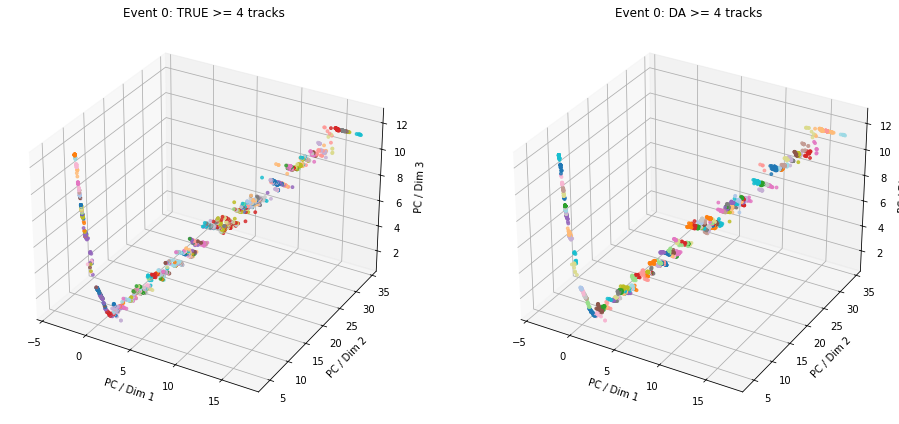

[Event 0] DA Clusters: 166, ARI=0.402, NMI=0.770


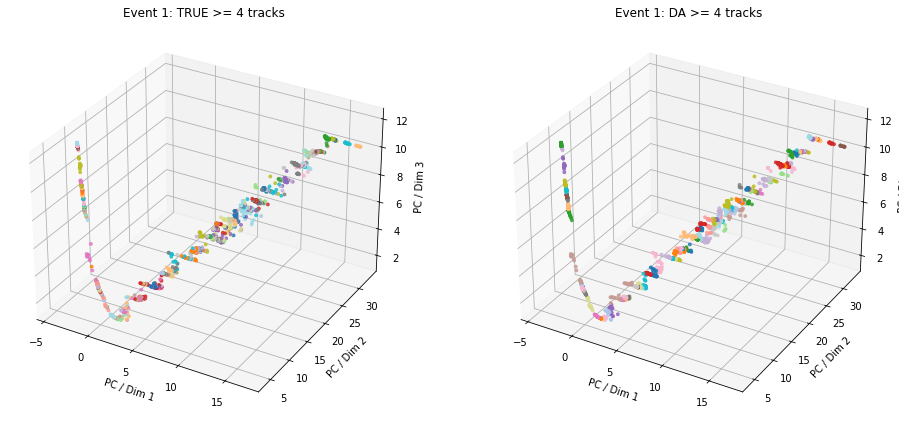

[Event 1] DA Clusters: 146, ARI=0.405, NMI=0.772


KeyboardInterrupt: 

In [9]:
da_labels_list = postprocess_clusters_deterministic_annealing(
    model=model,
    data_loader=test_loader,
    device=device,
    K=200,
    T_max=1,
    T_min=1e-1,
    cooling_rate=0.,
    init_method="random",
    min_cluster_size=4
)

In [ ]:
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_clustering(
    model,
    data_loader,
    eps=0.5,
    min_samples=15,
    min_track_count=4,
    dz_threshold=None,
    num_events_to_visualize=5
):
    
    import torch
    import numpy as np
    from sklearn.cluster import DBSCAN
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
    import matplotlib.pyplot as plt
    import seaborn as sns

    model.eval()
    ari_list = []
    nmi_list = []
    events_visualized = 0

    device = next(model.parameters()).device

    num_real_clusters_list = []
    num_pred_clusters_list = []
    real_multiplicities_list = []
    pred_multiplicities_list = []

    real_beta_values = []
    pred_beta_values = []
    real_dz_values = []
    pred_dz_values = []

    with torch.no_grad():
        for batch in (data_loader):
            batch = batch.to(device)
            
            x_ = batch.x.unsqueeze(0)         
            batch_ = batch.batch.unsqueeze(0) 
            dz_ = batch.dz.unsqueeze(0)       

            beta, embeddings = model(x_, batch_, dz_)
            dz = batch.dz 

            if(1>0):
                
                true_labels = batch.y

                
                valid_mask = (true_labels != -1)
                embeddings_i = embeddings[valid_mask]
                beta_i = beta[valid_mask]
                dz_i = dz[valid_mask]
                true_labels = true_labels[valid_mask]

                embeddings_i_np = embeddings_i.cpu().numpy()
                beta_i_np = beta_i.cpu().numpy()
                dz_i_np = dz_i.cpu().numpy()
                true_labels_np = true_labels.cpu().numpy()

               
                if dz_threshold is not None:
                    dz_mask = dz_i_np <= dz_threshold  
                    embeddings_i_np = embeddings_i_np[dz_mask]
                    beta_i_np = beta_i_np[dz_mask]
                    dz_i_np = dz_i_np[dz_mask]
                    true_labels_np = true_labels_np[dz_mask]

                
                beta_mask = beta_i_np > 0
                embeddings_i_np = embeddings_i_np[beta_mask]
                beta_i_np = beta_i_np[beta_mask]
                dz_i_np = dz_i_np[beta_mask]
                true_labels_np = true_labels_np[beta_mask]

                if embeddings_i_np.shape[0] == 0:
                    print(f"Event has no valid embeddings after masking. Skipping.")
                    continue

                
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                predicted_labels = dbscan.fit_predict(embeddings_i_np)

                if len(set(predicted_labels)) == 1 and predicted_labels[0] == -1:
                    predicted_labels = np.zeros_like(predicted_labels)

                ari = adjusted_rand_score(true_labels_np, predicted_labels)
                nmi = normalized_mutual_info_score(true_labels_np, predicted_labels)

                ari_list.append(ari)
                nmi_list.append(nmi)

                
                unique_real, counts_real = np.unique(true_labels_np, return_counts=True)
                valid_real_clusters = unique_real[counts_real >= min_track_count]
                real_mask = np.isin(true_labels_np, valid_real_clusters)
                filtered_real_labels = true_labels_np[real_mask]
                filtered_embeddings_real = embeddings_i_np[real_mask]
                filtered_beta_real = beta_i_np[real_mask]
                filtered_dz_real = dz_i_np[real_mask]

                unique_pred, counts_pred = np.unique(predicted_labels, return_counts=True)
                valid_pred_clusters = unique_pred[counts_pred >= min_track_count]
                pred_mask = np.isin(predicted_labels, valid_pred_clusters)
                filtered_pred_labels = predicted_labels[pred_mask]
                filtered_embeddings_pred = embeddings_i_np[pred_mask]
                filtered_beta_pred = beta_i_np[pred_mask]
                filtered_dz_pred = dz_i_np[pred_mask]

                num_real_clusters = len(unique_real_clusters := np.unique(filtered_real_labels))
                num_pred_clusters = len(unique_pred_clusters := np.unique(filtered_pred_labels))

                num_real_clusters_list.append(num_real_clusters)
                num_pred_clusters_list.append(num_pred_clusters)

                real_multiplicities = counts_real[counts_real >= min_track_count].tolist()
                pred_multiplicities = counts_pred[counts_pred >= min_track_count].tolist()

                real_multiplicities_list.extend(real_multiplicities)
                pred_multiplicities_list.extend(pred_multiplicities)

              
                for cluster_label in unique_real_clusters:
                    cluster_beta = filtered_beta_real[filtered_real_labels == cluster_label]
                    real_beta_values.extend(cluster_beta)

                    cluster_dz = filtered_dz_real[filtered_real_labels == cluster_label]
                    real_dz_values.extend(cluster_dz)

                for cluster_label in unique_pred_clusters:
                    cluster_beta = filtered_beta_pred[filtered_pred_labels == cluster_label]
                    pred_beta_values.extend(cluster_beta)

                    cluster_dz = filtered_dz_pred[filtered_pred_labels == cluster_label]
                    pred_dz_values.extend(cluster_dz)

                if events_visualized < num_events_to_visualize:
                    plot_embeddings(
                        embeddings=filtered_embeddings_real,
                        labels=filtered_real_labels,
                        title=f'True Clusters Event_{events_visualized+1}',
                        savefig=f'True_Clusters_Event_{events_visualized+1}.png'
                    )

                    plot_embeddings(
                        embeddings=filtered_embeddings_pred[filtered_pred_labels>0],
                        labels=filtered_pred_labels[filtered_pred_labels>0],
                        title=f'Predicted Clusters Event_{events_visualized+1}',
                        savefig=f'Predicted_Clusters_Event_{events_visualized+1}.png'
                    )

                    events_visualized += 1

    avg_ari = np.mean(ari_list) if ari_list else float('nan')
    avg_nmi = np.mean(nmi_list) if nmi_list else float('nan')
    print(f"Average Adjusted Rand Index (ARI): {avg_ari:.4f}")
    print(f"Average Normalized Mutual Information (NMI): {avg_nmi:.4f}")

    plot_track_multiplicity_histogram(real_multiplicities_list, pred_multiplicities_list)
    plot_cluster_counts_histogram(num_real_clusters_list, num_pred_clusters_list)

def plot_embeddings(embeddings, labels, title='Embeddings', savefig='true'):
    
    if embeddings.shape[1] >= 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(
            embeddings[:, 0], embeddings[:, 1], embeddings[:, 2],
            c=labels, cmap='tab20', s=20, alpha=0.6
        )
        ax.set_title(title)
        ax.set_xlabel('Embedding 1')
        ax.set_ylabel('Embedding 2')
        ax.set_zlabel('Embedding 3')
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
        cbar.set_label('Cluster Label')
    else:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(
            embeddings[:, 0], embeddings[:, 1],
            c=labels, cmap='tab20', s=20, alpha=0.6
        )
        plt.title(title)
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        cbar = plt.colorbar(scatter, ax=plt.gca())
        cbar.set_label('Cluster Label')

    plt.tight_layout()
    plt.savefig(f'{savefig}.png', dpi=300)
    plt.close()
    print(f"Saved plot as '{savefig}.png'")

def plot_cluster_counts_histogram(num_real_clusters, num_pred_clusters):
   
    bins = np.linspace(0, 200, num=201)  
    plt.figure(figsize=(10, 6))
    sns.histplot(num_real_clusters, color='blue', label='Real Clusters', kde=False, stat='count', bins=bins)
    sns.histplot(num_pred_clusters, color='orange', label='Predicted Clusters', kde=False, stat='count', bins=bins)
    plt.title('Number of Clusters per Event')
    plt.xlabel('# of Clusters')
    plt.ylabel('# of Events')
    plt.legend()
    plt.tight_layout()
    plt.savefig('cluster_counts_histogram.png', dpi=300)
    plt.close()
    

def plot_track_multiplicity_histogram(real_multiplicities, pred_multiplicities):
   
    plt.figure(figsize=(10, 6))
    
    combined_min = min(min(real_multiplicities, default=0), min(pred_multiplicities, default=0))
    combined_max = max(max(real_multiplicities, default=0), max(pred_multiplicities, default=0))
    
    bins = np.linspace(0, 100, num=101)  
    
    sns.histplot(real_multiplicities, color='blue', label='Real Clusters', kde=False, stat='count', bins=bins, alpha=0.6)
    sns.histplot(pred_multiplicities, color='orange', label='Predicted Clusters', kde=False, stat='count', bins=bins, alpha=0.6)
    
    plt.title('Track Multiplicity per Cluster')
    plt.xlabel('# of Tracks')
    plt.ylabel('Counts')
    plt.legend()
    plt.tight_layout()
    plt.savefig('track_multiplicity_histogram.png', dpi=300)
    plt.close()
   